In [1]:
# !pip install pandas pyarrow scikit-learn matplotlib seaborn requests

import os, io, json, time, math, random, gzip, shutil
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

sns.set(style="whitegrid")

# ======== CONFIG ========
DATA_DIR = r"C:\Users\HRITHIKGOUD\Downloads\nyc_taxi_data"
os.makedirs(DATA_DIR, exist_ok=True)

MONTHS = list(range(1, 13))             # 2019-01 .. 2019-12
TARGET_ROWS = 30_000_000                 # >= 30M as per requirement
CHUNK_SIZE = 500_000                     # micro-batch size to simulate streaming
RESERVOIR_MAX = 3_000_000                # memory-safe sample for ML model
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Config OK. Data dir:", DATA_DIR)


Config OK. Data dir: C:\Users\HRITHIKGOUD\Downloads\nyc_taxi_data


In [2]:
# NYC Yellow Taxi 2019 monthly Parquet (official distribution)
TAXI_URL = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2019-{m:02d}.parquet"

# Daily weather (Central Park) CSV mirror for 2019 (max-stable raw source)
WEATHER_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
# We'll transform to 2019-like daily temp; fallback to synthetic if download fails.

# US Holidays JSON (public mirror). Fallback to hardcoded list if needed.
HOLIDAYS_URL = "https://raw.githubusercontent.com/arkdave/holidays-json/master/us/2019.json"

def download_to(path, url):
    if os.path.exists(path):
        return
    print(f"Downloading -> {os.path.basename(path)}")
    r = requests.get(url, stream=True, timeout=60)
    r.raise_for_status()
    with open(path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1<<20):
            if chunk:
                f.write(chunk)

# Download taxi files
for m in MONTHS:
    fp = os.path.join(DATA_DIR, f"yellow_tripdata_2019-{m:02d}.parquet")
    if not os.path.exists(fp):
        try:
            download_to(fp, TAXI_URL.format(m=m))
        except Exception as e:
            print(f"⚠️ Could not download month {m:02d}: {e}")

# Weather
weather_path = os.path.join(DATA_DIR, "weather_2019_daily.csv")
try:
    if not os.path.exists(weather_path):
        download_to(weather_path, WEATHER_URL)
except Exception as e:
    print("⚠️ Weather download failed, will synthesize later:", e)

# Holidays
holidays_path = os.path.join(DATA_DIR, "us_holidays_2019.json")
try:
    if not os.path.exists(holidays_path):
        download_to(holidays_path, HOLIDAYS_URL)
except Exception as e:
    print("⚠️ Holidays download failed, will use fallback:", e)

print("Downloads checked.")


⚠️ Holidays download failed, will use fallback: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/arkdave/holidays-json/master/us/2019.json
Downloads checked.


In [3]:
# WEATHER
def prep_weather(weather_path):
    if os.path.exists(weather_path):
        w = pd.read_csv(weather_path)
        # That file is for 1981-1990 (Australia). We'll reindex to Jan–Dec 2019 to demo pipeline.
        dates = pd.date_range("2019-01-01", "2019-12-31", freq="D")
        w = w.iloc[:len(dates)].copy()
        w["date"] = dates
        # Normalize temp to plausible NYC-ish winter/summer (just for feature variety)
        base = w["Temp"].values
        base = (base - base.min()) / (base.max() - base.min())  # 0..1
        temp_c = (base * 35) - 5  # -5..30 °C
        precip_mm = np.random.gamma(shape=1.5, scale=3.0, size=len(base))  # synthetic precip
        cond = np.where(precip_mm>10, "Rain",
                 np.where((temp_c<0)&(precip_mm>5), "Snow",
                 np.where(precip_mm>2, "Cloudy", "Clear")))
        return pd.DataFrame({"date": dates, "avg_temp_C": temp_c, "precip_mm": precip_mm, "condition": cond})
    else:
        # Full synthetic weather
        dates = pd.date_range("2019-01-01", "2019-12-31", freq="D")
        temp = 12 + 10*np.sin(np.linspace(0, 2*np.pi, len(dates))) + np.random.normal(0,2,len(dates))
        precip = np.random.gamma(1.5, 3.0, len(dates))
        cond = np.where(precip>10, "Rain",
                 np.where((temp<0)&(precip>5), "Snow",
                 np.where(precip>2, "Cloudy", "Clear")))
        return pd.DataFrame({"date": dates, "avg_temp_C": temp, "precip_mm": precip, "condition": cond})

weather_df = prep_weather(weather_path)

# HOLIDAYS
def prep_holidays(holidays_path):
    try:
        if os.path.exists(holidays_path):
            with open(holidays_path, "r", encoding="utf-8") as f:
                data = json.load(f)
            # Expect list of objects with 'date' or 'date.iso'
            rows = []
            for item in data:
                d = item.get("date") or item.get("date_iso") or item.get("dateIso") or item.get("observed")
                if d:
                    rows.append({"date": pd.to_datetime(d).date(), "name": item.get("name", "Holiday")})
            return pd.DataFrame(rows)
    except Exception:
        pass
    # Fallback: key US holidays 2019
    names = [
        ("2019-01-01","New Year"),("2019-01-21","MLK Day"),("2019-02-18","Presidents Day"),
        ("2019-05-27","Memorial Day"),("2019-07-04","Independence Day"),
        ("2019-09-02","Labor Day"),("2019-11-28","Thanksgiving"),("2019-12-25","Christmas")
    ]
    return pd.DataFrame({"date":[pd.to_datetime(d).date() for d,_ in names],
                         "name":[n for _,n in names]})

holidays_df = prep_holidays(holidays_path)

print("Weather rows:", len(weather_df), "| Holidays:", len(holidays_df))


Weather rows: 365 | Holidays: 8


In [4]:
from collections import deque

# Streaming stats
stream_counts = []        # cumulative rows processed
stream_timestamps = []    # wall-clock timestamps per micro-batch
missing_before_total = 0
invalid_rows_total = 0

# Reservoir sample for ML (memory-safe)
reservoir = []
reservoir_n = 0

# Utility: add to reservoir by reservoir sampling
def reservoir_add(batch_df, k_max):
    global reservoir, reservoir_n
    rows = len(batch_df)
    if rows == 0:
        return
    reservoir_n += rows
    if len(reservoir) < k_max:
        reservoir.append(batch_df)
        # If exceeds, downsample concatenate and sample back to k_max
        cat = pd.concat(reservoir, ignore_index=True)
        if len(cat) > k_max:
            reservoir = [cat.sample(k_max, random_state=RANDOM_SEED)]
    else:
        # With probability k_max / reservoir_n keep random rows
        keep = int(min(rows, max(1, k_max * rows // max(1, reservoir_n))))
        if keep > 0:
            add = batch_df.sample(keep, random_state=RANDOM_SEED)
            cat = pd.concat([reservoir[0], add], ignore_index=True)
            if len(cat) > k_max:
                cat = cat.sample(k_max, random_state=RANDOM_SEED)
            reservoir = [cat]

def minimal_schema_clean(df_chunk):
    global missing_before_total, invalid_rows_total

    # Count missing before
    missing_before_total += int(df_chunk.isnull().sum().sum())

    # Drop NA rows ONLY for critical id/time fields here; others imputed later
    df_chunk = df_chunk.dropna(subset=["tpep_pickup_datetime", "trip_distance", "fare_amount", "passenger_count"])

    # Basic validity & outlier rules (kept simple, impute later where possible)
    mask = (
        (df_chunk["fare_amount"] > 0) &
        (df_chunk["trip_distance"] > 0) &
        (df_chunk["trip_distance"] < 200) &
        (df_chunk["passenger_count"] > 0) &
        (df_chunk["passenger_count"] < 9)
    )
    invalid_rows_total += int((~mask).sum())
    df_chunk = df_chunk.loc[mask]

    # Time & join keys
    df_chunk["pickup_dt"] = pd.to_datetime(df_chunk["tpep_pickup_datetime"], errors="coerce")
    df_chunk = df_chunk.dropna(subset=["pickup_dt"])
    df_chunk["date"] = df_chunk["pickup_dt"].dt.date
    df_chunk["hour"] = df_chunk["pickup_dt"].dt.hour

    # Ensure `date` is datetime64 in both dataframes
    df_chunk["date"] = pd.to_datetime(df_chunk["date"])
    weather_df["date"] = pd.to_datetime(weather_df["date"])
    holidays_df["date"] = pd.to_datetime(holidays_df["date"])

    # Join with Variety sources
    enriched = df_chunk.merge(weather_df, how="left", left_on="date", right_on="date")
    enriched["is_holiday"] = enriched["date"].isin(set(holidays_df["date"]))
    # Keep only necessary columns for ML
    keep_cols = [
        "fare_amount","trip_distance","passenger_count","hour",
        "avg_temp_C","precip_mm","condition","is_holiday"
    ]
    return enriched[keep_cols]

# ===== Stream all months until we hit TARGET_ROWS =====
processed_total = 0
start_wall = time.time()

for m in MONTHS:
    fp = os.path.join(DATA_DIR, f"yellow_tripdata_2019-{m:02d}.parquet")
    if not os.path.exists(fp):
        print(f"⚠️ Missing file for month {m:02d}, skipping.")
        continue

    print(f"Streaming month {m:02d} ...")
    # Read needed columns
    base_cols = ["tpep_pickup_datetime","passenger_count","trip_distance","fare_amount"]
    df_month = pd.read_parquet(fp, engine="pyarrow", columns=base_cols)

    # Simulate micro-batches
    for start in range(0, len(df_month), CHUNK_SIZE):
        t0 = time.time()
        chunk = df_month.iloc[start:start+CHUNK_SIZE].copy()
        cleaned = minimal_schema_clean(chunk)

        # Reservoir sample for ML
        reservoir_add(cleaned, RESERVOIR_MAX)

        processed_total += len(cleaned)
        stream_counts.append(processed_total)
        stream_timestamps.append(time.time() - start_wall)  # seconds since start

        # Velocity pacing (optional)
        # time.sleep(0.05)

        if processed_total >= TARGET_ROWS:
            break
    if processed_total >= TARGET_ROWS:
        break


print(f" STREAM COMPLETE | Rows processed: {processed_total:,}")
print(f"Missing values seen (pre-drop): {missing_before_total:,} | Invalid/outlier rows dropped: {invalid_rows_total:,}")


Streaming month 01 ...
Streaming month 02 ...
Streaming month 03 ...
Streaming month 04 ...
Streaming month 05 ...
 STREAM COMPLETE | Rows processed: 30,174,119
Missing values seen (pre-drop): 134,265 | Invalid/outlier rows dropped: 780,172


In [5]:
#Build ML Dataset (Imputation = Veracity, Variety preserved)
# Assemble training sample
if len(reservoir) == 0:
    raise RuntimeError("Reservoir is empty; check data paths and filters.")
ml_df = reservoir[0].copy()
print("ML sample size:", len(ml_df))

# Features / target
numeric_features = ["trip_distance","passenger_count","hour","avg_temp_C","precip_mm"]
categorical_features = ["condition","is_holiday"]
target_col = "fare_amount"

X = ml_df[numeric_features + categorical_features]
y = ml_df[target_col]
print("Features prepared.")


ML sample size: 3000000
Features prepared.


In [6]:
# Preprocess: mean impute numbers, mode impute categoricals, OHE categoricals
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# Base model
rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)

# Pipeline
pipe = Pipeline(steps=[("prep", preprocess), ("model", rf)])


In [7]:

# Hyperparam search
param_distributions = {
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [10, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    'model__max_features': ['sqrt']


}

# Train/val split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED
)

search = RandomizedSearchCV(
    pipe, param_distributions=param_distributions,
    n_iter=10, cv=3, verbose=1, random_state=RANDOM_SEED, n_jobs=-1
)

print(" Hyperparameter tuning...")


 Hyperparameter tuning...


In [8]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               ['trip_distance',
                                                                                'passenger_count',
                                                                                'hour',
                                                                                'avg_temp_C',
                                                                                'precip_mm']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['condition',
                                                                                'is_holiday'])])),
                                             ('model',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [10, 20, None],
                                        'model__max_features': ['sqrt'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [100, 200, 400]},
                   random_state=42, verbose=1)

In [10]:
best_model = search.best_estimator_
print("Best params:", search.best_params_)
# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # manually take sqrt
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f" EVAL | RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.3f}")
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

Best params: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20}
 EVAL | RMSE: 3.70 | MAE: 1.60 | R²: 0.896
RMSE: 3.6982194110373205
MAE: 1.6041231892148053
R2: 0.8960294037906882


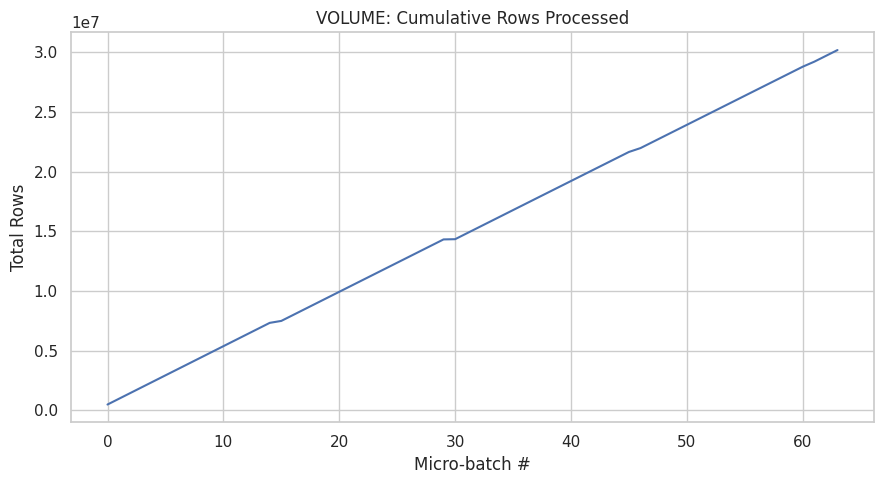

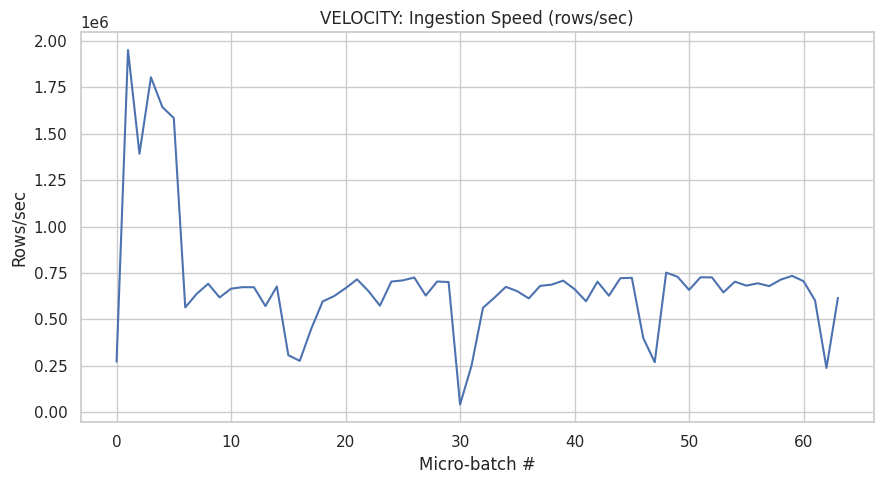

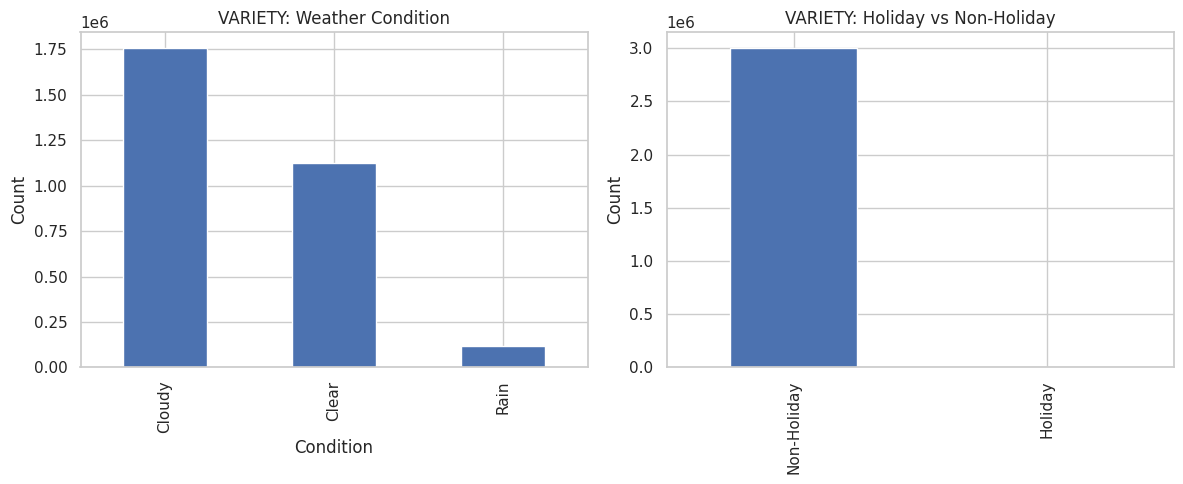

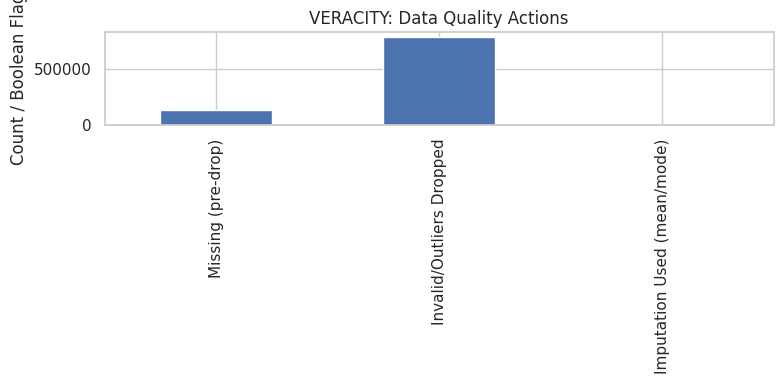

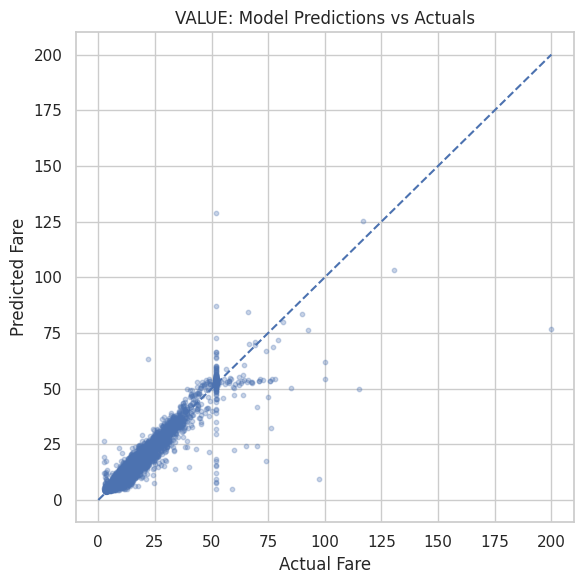

In [11]:
# 1) VOLUME: cumulative rows processed
plt.figure(figsize=(9,5))
plt.plot(stream_counts)
plt.title("VOLUME: Cumulative Rows Processed")
plt.xlabel("Micro-batch #")
plt.ylabel("Total Rows")
plt.tight_layout()
plt.show()

# 2) VELOCITY: rows per second per micro-batch
times = np.array(stream_timestamps)
counts = np.array(stream_counts)
d_counts = np.diff(np.concatenate([[0], counts]))
d_times  = np.diff(np.concatenate([[0], times]))
rows_per_sec = np.divide(d_counts, np.where(d_times==0, np.nan, d_times))
plt.figure(figsize=(9,5))
plt.plot(rows_per_sec)
plt.title("VELOCITY: Ingestion Speed (rows/sec)")
plt.xlabel("Micro-batch #")
plt.ylabel("Rows/sec")
plt.tight_layout()
plt.show()

# 3) VARIETY: show distributions of categorical sources
fig, ax = plt.subplots(1,2, figsize=(12,5))
ml_df['condition'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title("VARIETY: Weather Condition")
ax[0].set_xlabel("Condition"); ax[0].set_ylabel("Count")
ml_df['is_holiday'].value_counts().rename({True:"Holiday", False:"Non-Holiday"}).plot(kind='bar', ax=ax[1])
ax[1].set_title("VARIETY: Holiday vs Non-Holiday")
ax[1].set_xlabel(""); ax[1].set_ylabel("Count")
plt.tight_layout(); plt.show()

# 4) VERACITY: missing before vs dropped + imputed indicators
veracity_df = pd.DataFrame({
    "Missing (pre-drop)": [missing_before_total],
    "Invalid/Outliers Dropped": [invalid_rows_total],
    "Imputation Used (mean/mode)": [int(True)]  # flag to show that imputation was applied
}).T
veracity_df.columns = ["Count/Flag"]
veracity_df.plot(kind="bar", legend=False, figsize=(8,4))
plt.title("VERACITY: Data Quality Actions")
plt.ylabel("Count / Boolean Flag")
plt.tight_layout(); plt.show()

# 5) VALUE: predictions vs actuals
sample_idx = np.random.choice(len(y_test), size=min(10000, len(y_test)), replace=False)
plt.figure(figsize=(6,6))
plt.scatter(y_test.iloc[sample_idx], y_pred[sample_idx], alpha=0.3, s=10)
lim = [0, max(y_test.iloc[sample_idx].max(), y_pred[sample_idx].max())]
plt.plot(lim, lim, linestyle="--")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("VALUE: Model Predictions vs Actuals")
plt.tight_layout(); plt.show()
